空/読込不可のファイルをスキップ: ['奈良.csv']
             datetime  demand_10kW  temperature   humidity    precip  \
0 2021-01-01 00:00:00         1571     1.700000  70.285714  0.071429   
1 2021-01-01 01:00:00         1492     1.900000  69.428571  0.214286   
2 2021-01-01 02:00:00         1453     1.928571  68.000000  0.071429   
3 2021-01-01 03:00:00         1412     1.628571  70.285714  0.142857   
4 2021-01-01 04:00:00         1358     1.871429  71.142857  0.071429   

   dew_point  wind_speed      snow  
0  -3.328571    3.971429  0.142857  
1  -3.271429    3.571429  0.285714  
2  -3.557143    4.100000  0.000000  
3  -3.400000    3.857143  0.285714  
4  -2.971429    3.814286  0.000000  
17496 8760 features: 16
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 17496, number of used features: 16
[Li

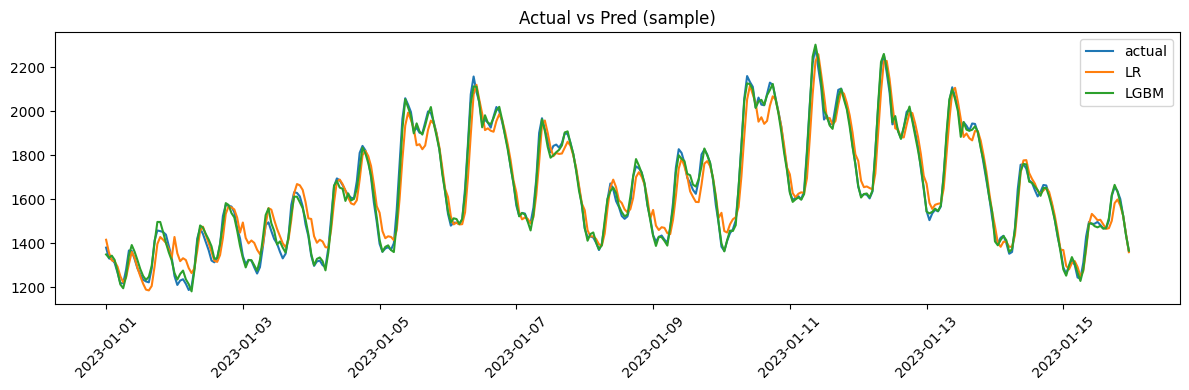


Feature Importance (top 15):
lag1           16292
hour           14679
lag24          14220
ma24           13662
wind_speed     12834
humidity       12618
dew_point      11257
temperature     9390
dow             5651
CDD             3605
HDD             3127
precip          2818
temp2           2758
is_holiday       696
is_weekend       273
dtype: int32

◆ ピーク帯(LGBM) MAE=17.27, RMSE=22.76


In [ ]:
# ===== Colab用セットアップ =====
!pip -q install lightgbm jpholiday

# ===== インポート =====
import os
import numpy as np
import pandas as pd
import jpholiday
from datetime import datetime
from pandas.errors import EmptyDataError
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt

# ===== 入力ファイル =====
DEMAND_CSV = '/content/電力需要.csv'  # 列: datetime, 当日実績(万kW)
WEATHER_FILES = [
	'/content/大阪.csv','/content/京都.csv','/content/奈良.csv','/content/彦根.csv',
	'/content/潮岬.csv','/content/神戸.csv','/content/豊岡.csv','/content/和歌山.csv'
]

# ===== 設定 =====
BASELINE_JPY = 7_200_000_000	# 現状72億円（比較用）

# ===== ユーティリティ =====
# 特徴量作成（未来情報リーク防止）
def add_features(d):
	d = d.copy()
	d["hour"] = d["datetime"].dt.hour
	d["dow"] = d["datetime"].dt.dayofweek
	d["is_weekend"] = (d["dow"] >= 5).astype(int)
	d["is_holiday"] = d["datetime"].apply(lambda x: int(jpholiday.is_holiday(x)))
	d["lag1"] = d["demand_10kW"].shift(1)
	d["lag24"] = d["demand_10kW"].shift(24)
	d["ma24"] = d["demand_10kW"].shift(1).rolling(24).mean()
	if "temperature" in d.columns:
		d["temp2"] = d["temperature"] ** 2
		d["CDD"] = (d["temperature"] - 24).clip(lower=0)
		d["HDD"] = (18 - d["temperature"]).clip(lower=0)
	return d

# 年間トータル式
# インバランス料金（円）＝ ｛|予測電力量合計 − 実績電力量合計|（万kWh）｝² × 0.8
# 1時間の万kWは合計すると万kWh（1h）として扱う
def imbalance_cost_total_year(y_true: pd.Series, y_pred: pd.Series, rate: float = 0.8):
	paired = pd.concat([y_true.rename("y_true"), y_pred.rename("y_pred")], axis=1).dropna()
	if paired.empty:
		return np.nan, np.nan, np.nan, np.nan
	total_true = float(paired["y_true"].sum())	# 万kWh
	total_pred = float(paired["y_pred"].sum())	# 万kWh
	diff = abs(total_pred - total_true)			# 万kWh
	return (diff ** 2) * rate, total_true, total_pred, diff

# 点ごとの誤差（参考用）
def evaluate_pointwise(y_true: pd.Series, y_pred: pd.Series, label=""):
	paired = pd.concat([y_true.rename("y_true"), y_pred.rename("y_pred")], axis=1).dropna()
	if paired.empty:
		print(f"[{label}] 有効データなし"); return np.nan, np.nan
	mae = mean_absolute_error(paired["y_true"], paired["y_pred"])
	rmse = np.sqrt(mean_squared_error(paired["y_true"], paired["y_pred"]))
	print(f"[{label}] MAE={mae:.2f}, RMSE={rmse:.2f}")
	return mae, rmse

# 72億円との比較表示
def compare_to_baseline(label: str, cost: float, base: float = BASELINE_JPY):
	diff = base - cost
	rate = (diff / base) * 100
	status = "改善" if diff > 0 else "悪化" if diff < 0 else "同等"
	print(f"{label:20s}  コスト={cost:>13,.0f} 円 | 基準比 {status}: {diff:>13,.0f} 円 ({rate:+.2f}%)")

# ===== データ読み込み =====
# 需要
demand_df = pd.read_csv(DEMAND_CSV, encoding='utf-8', parse_dates=['datetime'])
demand_df = demand_df.rename(columns={"当日実績(万kW)": "demand_10kW"})
demand_df = demand_df[['datetime','demand_10kW']].sort_values('datetime')

# 気象（空ファイルはスキップ）
weather_list, skipped = [], []
for path in WEATHER_FILES:
	try:
		dfw = pd.read_csv(path, encoding='utf-8', parse_dates=['datetime'])
	except EmptyDataError:
		skipped.append(path); continue
	if dfw.empty or dfw.dropna(how='all').empty:
		skipped.append(path); continue
	dfw = dfw.rename(columns={
		"降水量": "precip","気温": "temperature","露点温度": "dew_point",
		"湿度": "humidity","風速": "wind_speed","風向": "wind_dir","降雪": "snow"
	})
	dfw['prefecture'] = os.path.basename(path).replace('.csv','')
	weather_list.append(dfw)

if not weather_list:
	raise ValueError("気象CSVがすべて空/読込不可でした。")
if skipped:
	print("空/読込不可のファイルをスキップ:", [os.path.basename(p) for p in skipped])

weather_raw = pd.concat(weather_list, ignore_index=True)
weather_mean = (
	weather_raw[['datetime','temperature','humidity','precip','dew_point','wind_speed','snow']]
	.groupby('datetime', as_index=False)
	.mean(numeric_only=True)
)

# 需要×気象の結合
df = demand_df.merge(weather_mean, on='datetime', how='inner').sort_values('datetime').reset_index(drop=True)
print(df.head())

# ===== 特徴量・インデックス =====
df_feat = add_features(df).dropna().reset_index(drop=True)
df_feat = df_feat.set_index('datetime').sort_index()

# ===== 期間分割 =====
train_end = pd.Timestamp("2022-12-31 23:00")
test_start = pd.Timestamp("2023-01-01 00:00")
test_end   = pd.Timestamp("2023-12-31 23:00")

features = [c for c in [
	"temperature","humidity","precip","dew_point","wind_speed","snow",
	"temp2","CDD","HDD","hour","dow","is_weekend","is_holiday","lag1","lag24","ma24"
] if c in df_feat.columns]

X_train = df_feat.loc[:train_end, features]
y_train = df_feat.loc[:train_end, "demand_10kW"]
X_test  = df_feat.loc[test_start:test_end, features]
y_test  = df_feat.loc[test_start:test_end, "demand_10kW"]

print(len(X_train), len(X_test), "features:", len(features))

# ===== 学習・予測 =====
# 線形回帰
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = pd.Series(lr.predict(X_test), index=X_test.index)

# LightGBM
lgbm = lgb.LGBMRegressor(
	n_estimators=2000, learning_rate=0.03, num_leaves=63,
	subsample=0.8, colsample_bytree=0.8, min_child_samples=20,
	reg_alpha=0.1, reg_lambda=0.2, random_state=42
)
lgbm.fit(X_train, y_train)
pred_lgb = pd.Series(lgbm.predict(X_test), index=X_test.index)

# ===== 参考：点ごとの誤差 =====
_ = evaluate_pointwise(y_test, pred_lr,  "LinearRegression")
_ = evaluate_pointwise(y_test, pred_lgb, "LightGBM")

# ===== 年間インバランス料金 =====
cost_lr,  act_mankwh, pred_lr_sum,  diff_lr  = imbalance_cost_total_year(y_test, pred_lr)
cost_lgb, _,           pred_lgb_sum, diff_lgb = imbalance_cost_total_year(y_test, pred_lgb)

print("\n◆ 年間インバランス料金（合計差方式, {|予測合計−実績合計|}^2 × 0.8）")
print(f"LinearRegression : {cost_lr:,.2f} 円  [実績合計={act_mankwh:,.2f} 万kWh, 予測合計={pred_lr_sum:,.2f} 万kWh, 差分={diff_lr:,.2f} 万kWh]")
print(f"LightGBM         : {cost_lgb:,.2f} 円  [実績合計={act_mankwh:,.2f} 万kWh, 予測合計={pred_lgb_sum:,.2f} 万kWh, 差分={diff_lgb:,.2f} 万kWh]")

# ===== 72億円（現状）との比較 =====
print("\n◆ 72億円(現状) 基準での比較")
compare_to_baseline("LinearRegression", cost_lr)
compare_to_baseline("LightGBM",        cost_lgb)

# ===== 誤差分析・可視化 =====
res = pd.DataFrame({
	"y": y_test,
	"pred_lr": pred_lr,
	"pred_lgb": pred_lgb,
	"temperature": df_feat.loc[y_test.index, "temperature"]
}).dropna()

res["abs_lr"] = (res["y"] - res["pred_lr"]).abs()
res["abs_lgb"] = (res["y"] - res["pred_lgb"]).abs()
res["hour"] = res.index.hour

print("\n◆ 時間帯別 平均絶対誤差（万kW）")
print(res.groupby("hour")[["abs_lr","abs_lgb"]].mean().round(2))

bins = [-50,0,10,20,25,30,50]
labels = ["<0","0-10","10-20","20-25","25-30",">=30"]
res["temp_bin"] = pd.cut(res["temperature"], bins=bins, labels=labels, right=False)
print("\n◆ 気温帯別 平均絶対誤差（万kW）")
print(res.groupby("temp_bin", observed=True)[["abs_lr","abs_lgb"]].mean().round(2))

# 可視化（冒頭15日=360点）
sample = res.iloc[:360].copy()
plt.figure(figsize=(12,4))
plt.plot(sample.index, sample["y"], label="actual")
plt.plot(sample.index, sample["pred_lr"], label="LR")
plt.plot(sample.index, sample["pred_lgb"], label="LGBM")
plt.legend(); plt.title("Actual vs Pred (sample)"); plt.xticks(rotation=45); plt.tight_layout()
plt.show()

# 特徴量重要度（参考）
imp = pd.Series(lgbm.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature Importance (top 15):")
print(imp.head(15))

# ピーク帯（7–10, 17–20）
peak_mask = res["hour"].isin([7,8,9,10,17,18,19,20])
mae_p = mean_absolute_error(res.loc[peak_mask,"y"], res.loc[peak_mask,"pred_lgb"])
rmse_p = np.sqrt(mean_squared_error(res.loc[peak_mask,"y"], res.loc[peak_mask,"pred_lgb"]))
print(f"\n◆ ピーク帯(LGBM) MAE={mae_p:.2f}, RMSE={rmse_p:.2f}")




- ## 1. 目的
関西エリアの電力量（1時間粒度・万kW）を高精度に予測し、指定のインバランス式でビジネス効果を金額換算する。  
**簡易式**：インバランス料金（円）＝ {｜予測電力量合計 − 実績電力量合計｜（万kWh）}² × 0.8

---

- ## 2. データ・前処理
- 需要：`datetime（1時間粒度）`, `当日実績(万kW)`→`demand_10kW`
- 気象：近畿8地点（空CSVは自動スキップ）。地点平均を「関西代表値」として採用
- 同一 `datetime（1時間）` で内部結合、昇順整列
- 期間：学習＝〜2022-12-31 23:00／評価＝2023-01-01〜2023-12-31

---

- ## 3. 特徴量設計・手法選定理由
**特徴量**  
- カレンダー要因：時間（hour）、曜日（dow）、週末フラグ（is_weekend）、祝日フラグ（is_holiday）
- 過去の需要データ：直前の値（lag1）、24時間前の値（lag24）、直近24時間の平均（ma24）
- 気象要因とその加工：気温（temperature）、湿度（humidity）、降水量（precip）、露点温度（dew_point）、風速（wind_speed）、降雪（snow）、気温の二乗（temp2）、冷房需要指標（CDD）、暖房需要指標（HDD）

**手法**  
- ベースライン：線形回帰（LR）…シンプルで解釈性が高い  
- 本モデル：LightGBM（LGBM）…非線形・相互作用を自動学習、計算も高速  

**重要度（LGBM上位）**  
 - 上位に効いたのは 「直前の需要」、「時刻」、「前日の同じ時刻の需要」、「直近24時間の平均需要」
 - 続いて、風速・湿度・露点・気温といった気象要素が寄与
 - 需要の繰り返しパターン（直前・日内・前日同時刻）が中心で、気象要因が補助的に効いている構造

---

- ## 4. モデル評価
**評価指標**  
- MAE（平均絶対誤差）：平均的な外し幅を表す指標  
- RMSE（二乗平均平方根誤差）：大きな外しを強調する指標（ピーク外れに敏感）  
- 簡易インバランス式：年間合計差を金額換算。現状想定72億円と比較


**結果（2023年）**  
| 指標 | LinearRegression | LightGBM |
|---|---:|---:|
| MAE | 47.00 | **14.55** |
| RMSE | 62.71 | **20.13** |
| 年間インバランス（円） | 2,358,174,003 | **1,269,063,023** |

- 実績合計：13,941,025.00 万kWh  
- LGBM予測合計：13,980,853.74 万kWh（差分 39,828.74 万kWh）  

**72億円（現状）との比較**  
- LGBM：▲5,930,936,977 円（+82.37%改善）  
- LR　：▲4,841,825,997 円（+67.25%改善）

> 結論：形の精度・金額換算ともに LightGBM が優れている

---

- ## 5. 分析・考察

### 誤差分析（現状の課題）
- **時間帯**  
  - 朝/夕ピーク（7–10時, 17–20時）で誤差が大きい  
  - 例：17時 MAE=22.47  
  - 深夜帯は MAE 8〜11 程度で安定
- **気温帯**  
  - 30℃以上で誤差が増加（MAE=26.54）  
  - 湿度・日射・蓄熱など「熱要因」が効いている
- **構造的要因**  
  - 前の時間や前日の同じ時間の値から、ある程度需要を説明できる  
  - つまり「毎日同じような時間帯に似た動きをする」という規則性が強い
  - ただし突発イベント・猛暑連続には弱い

---

### 精度改善の仮説
1. **ピーク対策**  
   - ピーク重み付け学習  
   - ピーク専用サブモデルの導入
2. **暑熱要因の強化**  
   - ヒートインデックス（気温×湿度）  
   - 連続猛暑日カウント  
   - 前日ピークや立ち上がり速度を特徴量に追加
3. **外部データの活用**  
   - 日射・雲量などの気象要素  
   - 学校暦・イベント・連休等のカレンダー要因
4. **モデル分解**  
   - 季節別（夏/冬）  
   - 曜日別（平日/休日）

---

### ビジネスインパクト
- **収益面**  
  - 現状 72億円 → 約12.7億円（▲59.3億円, 改善率82.37%）の削減ポテンシャル
- **業務面**  
  - 予測自動化により工数を削減  
  - 乖離アラートで当日判断を迅速化
- **組織面**  
  - 予測の精度向上により、余剰インバランスのペナルティを回避できる(リスクヘッジ)
  - 要因の共有により、調達・販売・企画の意思決定を促進

---

### 今後の展望
- **短期（〜3か月）**  
  - 現行手法と並走しながら PoC を実施
  - 予報の取り込み：翌日以降の気象予報を外生変数として注入
  - 日次自動予測の配信と乖離アラートを運用に組込み  
  - 効果：現場担当者の作業負担を削減し、乖離発生時の即応性を向上

- **中期（〜1年）**  
  - 本番導入：監視体制の構築、失敗時のフォールバックルール、モデル更新サイクルを整備  
  - ダッシュボードを活用し、需要変動要因を「見える化」  
  - 効果：経営層〜現場が共通のKPIを共有でき、説明責任と意思決定がスムーズに

- **高度化（1〜2年）**  
  - ピーク時に特化した学習（重み付けや専用サブモデル）  
  - 暑熱・厳寒対応の特徴量（ヒートインデックス、連続猛暑日、前日ピークなど）  
  - 外部データ（日射・雲量・学校暦・イベント情報）の導入  
  - 効果：猛暑や繁忙期における外れ値を抑制し、リスクコストをさらに削減

- **将来（2年〜）**  
  - 30分粒度での予測に対応し、制度上の精算単位に合わせたモデルに進化  
  - 効果：ピーク立ち上がりの挙動をより正確に追従し、制度精算に近い形でのリスク管理が可能に

In [ ]:
from google.colab import drive
drive.mount('/content/drive')